# Исследование закономерностей, определяющих успешность компьютерных игр

Из открытых источников доступны исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Вам нужно выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.


Перед нами данные до 2016 года. Цель проекта - прогноз на 2017 год.

# Шаги исследования

1. Подготовка данных.
2. Исследовательский анализ данных.
3. Составление портрета пользователя каждого региона.
4. Проверка гипотез.
5. Общий вывод.

# 1. Подготовка данных

In [33]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st
data = pd.read_csv('/datasets/games.csv')
data.info() # Изучим общую информацию о датафрейме

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


In [34]:
# Приводим названия столбцов к нижнему регистру
data.columns = map(str.lower, data.columns)
data.columns

Index(['name', 'platform', 'year_of_release', 'genre', 'na_sales', 'eu_sales',
       'jp_sales', 'other_sales', 'critic_score', 'user_score', 'rating'],
      dtype='object')

In [35]:
# Меняем типы данных столбцов датафрейма, заполняем пропуски
data.head(30)
data.loc[data['user_score'] == 'tbd', 'user_score'] = np.nan # Заменили 'tbd' на пропуски
data = data.dropna(subset=['year_of_release'])
data['year_of_release'] = data['year_of_release'].astype('int16')
data['rating'] = data['rating'].fillna('no')
data['critic_score'] = data['critic_score'].astype('float16')
data['user_score'] = data['user_score'].astype('float16')

В столбце 'user_score' содержались значения 'tbd' (в переводе с английского: "подлежит уточнению"). Заменили данные значения на пропуски.

Тип данных в столбце 'user_score' был изменён с object на float16, так в нем содержались числа с плавающей точкой (за исключением NaN и значения 'tbd' - они уже отработаны). 

Тип данных в столбце 'critic_score' был изменён с object на float16.

В столбцe 'rating' пропуски заменены на значение 'no'. Удаление строк с пропусками в этом столбце будет ошибочным - потеряется слишком много данных.  

Строки, содержащие пропуски в столбце 'year_of_release', были удалены.

Причины появления пропусков: 1) Человеческий фактор; 2) Некоторые данные могли потеряться при выгрузке.

In [36]:
# Меняем типы данных столбцов датафрейма
columns_for_retype = ['na_sales', 'eu_sales', 'jp_sales', 'other_sales']
for i in columns_for_retype:
    data[i] = data[i].astype('float16')
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16446 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   name             16444 non-null  object 
 1   platform         16446 non-null  object 
 2   year_of_release  16446 non-null  int16  
 3   genre            16444 non-null  object 
 4   na_sales         16446 non-null  float16
 5   eu_sales         16446 non-null  float16
 6   jp_sales         16446 non-null  float16
 7   other_sales      16446 non-null  float16
 8   critic_score     7983 non-null   float16
 9   user_score       7463 non-null   float16
 10  rating           16446 non-null  object 
dtypes: float16(6), int16(1), object(4)
memory usage: 867.3+ KB


В столбцах 'na_sales', 'eu_sales', 'jp_sales', 'other_sales' был изменён тип данных с float64 на float16 для экономии ячеек памяти. 

In [37]:
# Создаем столбец - суммарные продажи со всех регионов
data['sum_profit'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']

# 2. Исследовательский анализ данных

In [38]:
# Количество игр, выпущенных за каждый год
data['year_of_release'].value_counts()

2008    1427
2009    1426
2010    1255
2007    1197
2011    1136
2006    1006
2005     939
2002     829
2003     775
2004     762
2012     653
2015     606
2014     581
2013     544
2016     502
2001     482
1998     379
2000     350
1999     338
1997     289
1996     263
1995     219
1994     121
1993      62
1981      46
1992      43
1991      41
1982      36
1986      21
1983      17
1989      17
1990      16
1987      16
1988      15
1985      14
1984      14
1980       9
Name: year_of_release, dtype: int64

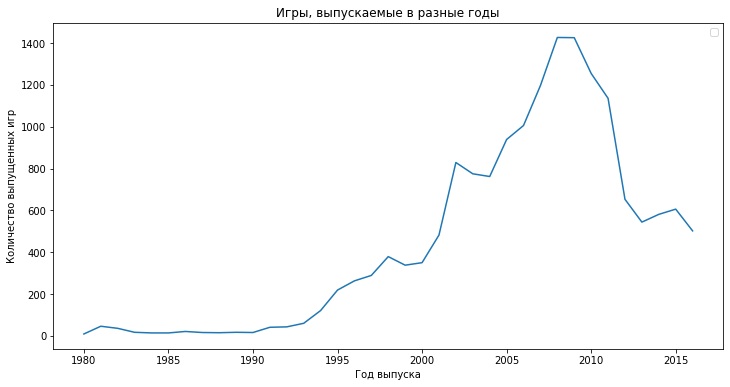

In [39]:
# Визуализируем данные 
games_on_period = data.pivot_table(index='year_of_release', values='name', aggfunc='count')
plt.figure(figsize=(12,6))
sns.lineplot(data=games_on_period)
plt.title("Игры, выпускаемые в разные годы")
plt.xlabel("Год выпуска")
plt.ylabel("Количество выпущенных игр")
plt.legend('')

В нулевые годы произошел резкий скачок выпуска игр. Это связано с развитием и созданием различных игровых консолей.

Для нас важны данные, начиная с 2000-го года. 

Text(0, 0.5, 'Количество проданных консолей')

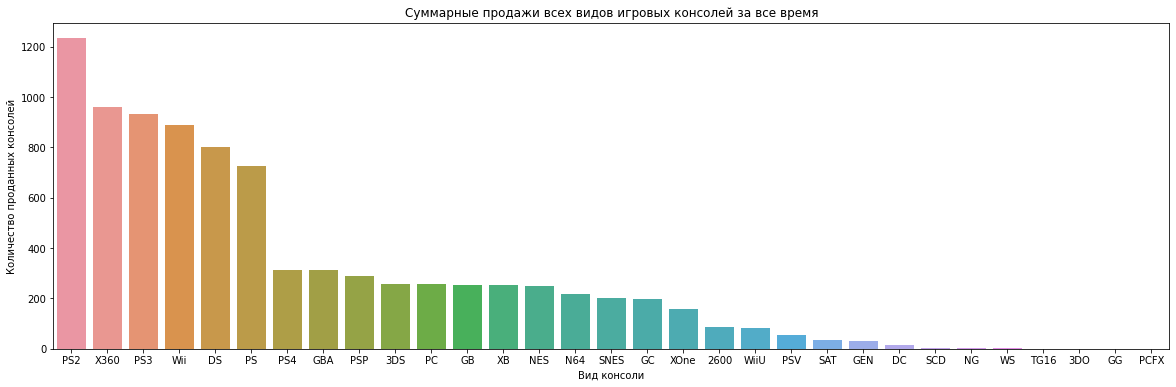

In [40]:
# Вычисляем суммарные продажи по всем платформам
dif_plat = data.pivot_table(index="platform", values="sum_profit", aggfunc="sum").sort_values(by="sum_profit", ascending=False)
plt.figure(figsize=(20,6))
sns.barplot(x=dif_plat.index,y=dif_plat['sum_profit'])
plt.title("Суммарные продажи всех видов игровых консолей за все время")
plt.xlabel("Вид консоли")
plt.ylabel("Количество проданных консолей")

Наибольшие суммарные продажи у консолей: PS2, X360, PS3, Wii, DS.

In [41]:
# Находим топ-5 платформ по продажам
top_5_platforms = dif_plat.head(5)
top_5_platforms = top_5_platforms.reset_index().rename_axis(None, axis=1)
top_5_platforms

,platform,sum_profit
0,PS2,1234.0
1,X360,961.0
2,PS3,931.5
3,Wii,891.0
4,DS,803.0


In [42]:
# Функция, которая делает сводную таблицу по данным, начиная с 2003-го года
def top_5_platforms_sales(name, data):
    a = data[(data['platform'] == name) & (data['year_of_release'] >= 2003)]
    b = a.pivot_table(index="year_of_release", values="sum_profit", aggfunc="sum")
    return b

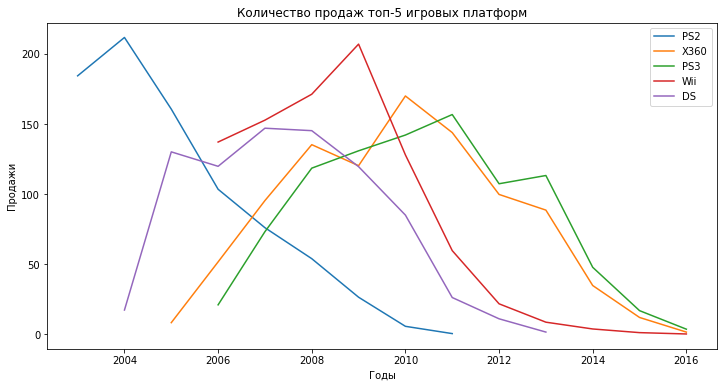

In [43]:
# Cтроим распределение по годам, применяя функцию top_5_platforms_sales
plt.figure(figsize=(12,6))
plt.title('Количество продаж топ-5 игровых платформ')
plt.xlabel('Годы')
plt.ylabel('Продажи')
for i in top_5_platforms['platform']:
    sns.lineplot(data=top_5_platforms_sales(i, data)['sum_profit'], label=i)
    plt.legend()

В среднем, "жизнь" игровых консолей составляет около 9-11 лет. Пик продажи - середина продолжительности "жизни" (4-6 лет).

Актуальный период: 2014 и по настоящее время - 2016 год.

In [44]:
# Актуальные данные
actual_data = data[(data['year_of_release'] >= 2014) & (data['sum_profit'] < 1.8)]
actual_data

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sum_profit
976,The Evil Within,PS4,2014,Action,0.549805,0.859863,0.109985,0.270020,75.0,7.300781,M,1.791016
1007,Madden NFL 17,PS4,2016,Sports,1.250000,0.170044,0.000000,0.320068,82.0,4.898438,E,1.740234
1012,The Elder Scrolls Online,PS4,2015,Role-Playing,0.669922,0.790039,0.000000,0.290039,NaN,NaN,no,1.750000
1021,Watch Dogs,PS3,2014,Action,0.560059,0.810059,0.099976,0.270020,NaN,5.101562,M,1.740234
1026,The Order: 1886,PS4,2015,Shooter,0.609863,0.779785,0.059998,0.270020,63.0,6.601562,M,1.718750
...,...,...,...,...,...,...,...,...,...,...,...,...
16703,Strawberry Nauts,PSV,2016,Adventure,0.000000,0.000000,0.010002,0.000000,NaN,NaN,no,0.010002
16707,Aiyoku no Eustia,PSV,2014,Misc,0.000000,0.000000,0.010002,0.000000,NaN,NaN,no,0.010002
16710,Samurai Warriors: Sanada Maru,PS3,2016,Action,0.000000,0.000000,0.010002,0.000000,NaN,NaN,no,0.010002
16712,Haitaka no Psychedelica,PSV,2016,Adventure,0.000000,0.000000,0.010002,0.000000,NaN,NaN,no,0.010002


Text(0, 0.5, 'Глобальные продажи за актуальный период')

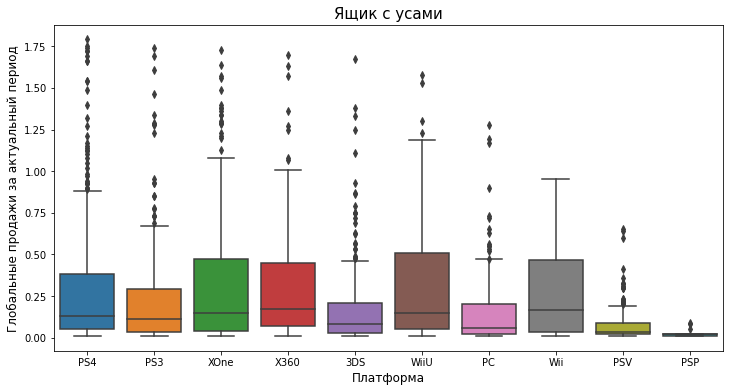

In [45]:
# Построение "ящика с усами" в разбивке по платформам
plt.figure(figsize=(12,6))
sns.boxplot(data=actual_data, x='platform', y='sum_profit')
plt.title('Ящик с усами', fontsize=15)
plt.xlabel('Платформа', fontsize=12)
plt.ylabel('Глобальные продажи за актуальный период', fontsize=12)

Топ-5 по продажам за актуальный период:
1. WiiU
2. XOne
3. X360
4. Wii
5. PS4

In [46]:
# Вычислим корреляцию и построим диаграмму рассеивания для платформы PS4
ps_4_platform = actual_data[actual_data['platform'] == 'PS4']
ps_4_platform

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating,sum_profit
976,The Evil Within,PS4,2014,Action,0.549805,0.859863,0.109985,0.270020,75.0,7.300781,M,1.791016
1007,Madden NFL 17,PS4,2016,Sports,1.250000,0.170044,0.000000,0.320068,82.0,4.898438,E,1.740234
1012,The Elder Scrolls Online,PS4,2015,Role-Playing,0.669922,0.790039,0.000000,0.290039,NaN,NaN,no,1.750000
1026,The Order: 1886,PS4,2015,Shooter,0.609863,0.779785,0.059998,0.270020,63.0,6.601562,M,1.718750
1035,The Crew,PS4,2014,Racing,0.350098,1.080078,0.029999,0.260010,61.0,5.398438,T,1.719727
...,...,...,...,...,...,...,...,...,...,...,...,...
16500,Root Letter,PS4,2016,Adventure,0.000000,0.000000,0.010002,0.000000,69.0,7.500000,no,0.010002
16503,Shin Hayarigami 2,PS4,2016,Adventure,0.000000,0.000000,0.010002,0.000000,NaN,NaN,no,0.010002
16526,Dungeons 2,PS4,2016,Role-Playing,0.010002,0.000000,0.000000,0.000000,61.0,7.898438,T,0.010002
16530,Carmageddon: Max Damage,PS4,2016,Action,0.010002,0.000000,0.000000,0.000000,51.0,5.500000,M,0.010002


In [47]:
# Корреляция между оценками критиков и продажами 
ps_4_platform['critic_score'].corr(ps_4_platform['sum_profit'])

0.2805654629231388

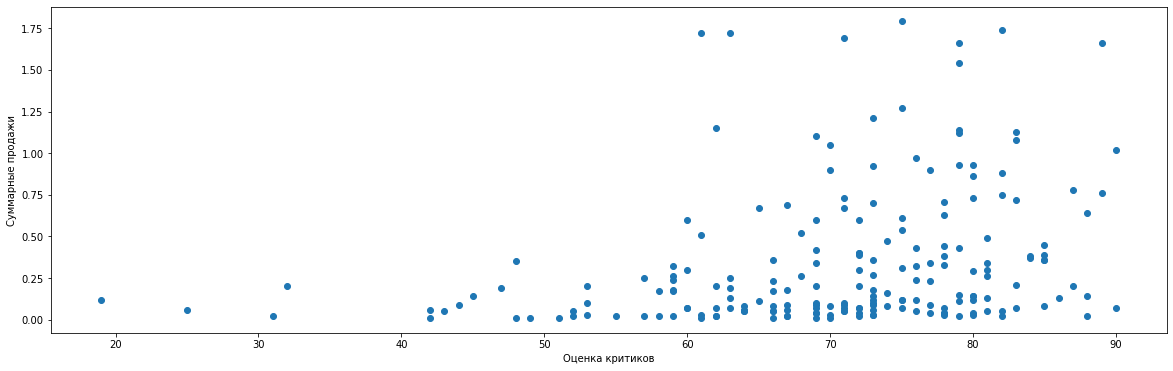

In [48]:
# Диаграмма рассеяния между оценками критиков и продажами
fig, ax = plt.subplots(figsize=(20, 6))
ax.scatter(x = ps_4_platform['critic_score'] , y = ps_4_platform['sum_profit'])
plt.xlabel("Оценка критиков")
plt.ylabel("Суммарные продажи")
plt.show()

In [49]:
# Корреляция между оценками пользователей и продажами
ps_4_platform['user_score'].corr(ps_4_platform['sum_profit'])

0.01007265502987827

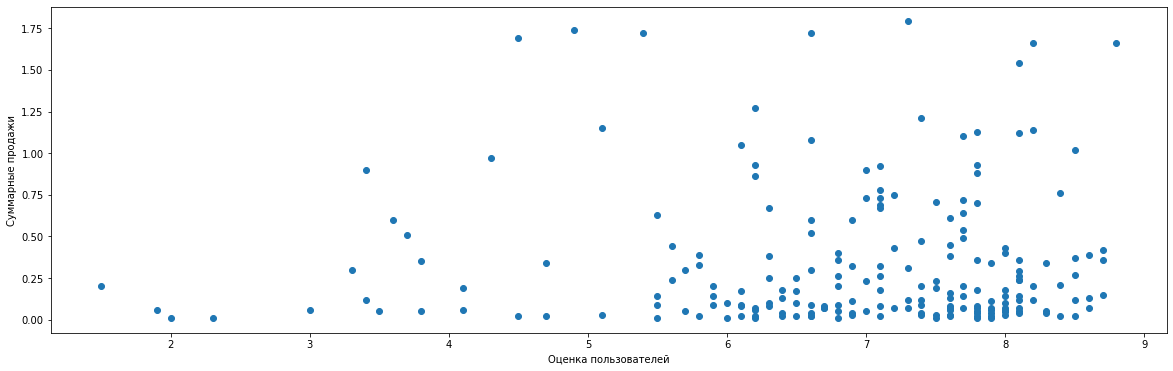

In [50]:
# Диаграмма рассеяния между оценками критиков и продажами
fig, ax = plt.subplots(figsize=(20, 6))
ax.scatter(x = ps_4_platform['user_score'] , y = ps_4_platform['sum_profit'])
plt.xlabel("Оценка пользователей")
plt.ylabel("Суммарные продажи")
plt.show()

Вывод:
1. В целом можно сказать, что в обоих случаях взаимосвязь между отзывами и продажами присутствует.
2. Отзывы критиков имеют гораздо большее влияние на суммарные продажи на платформе PS4, нежели отзывы пользователей.


Для платформы Wii строить диаграмму рассеивания и корреляцию не будем, так как для нее нет ни одной оценки от критиков и пользователей.

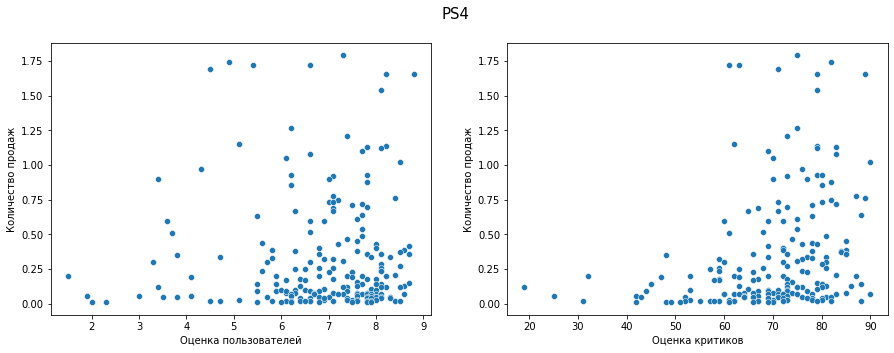

Корреляция между отзывами критиков и продажами:  0.2805654629231388
Корреляция между отзывами пользователей и продажами: 0.01007265502987827


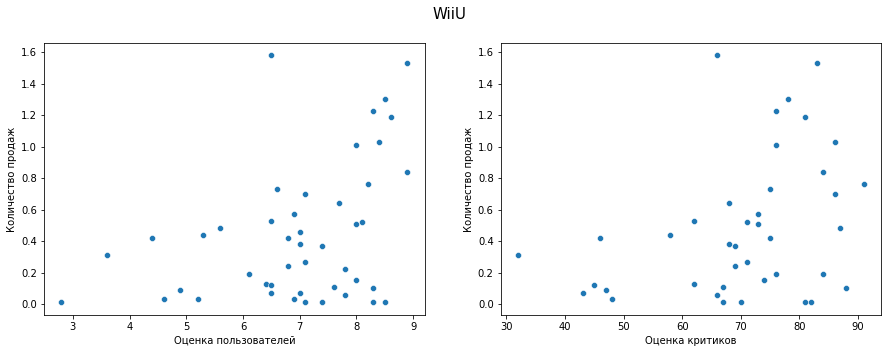

Корреляция между отзывами критиков и продажами:  0.35776949223337573
Корреляция между отзывами пользователей и продажами: 0.38927369618318153


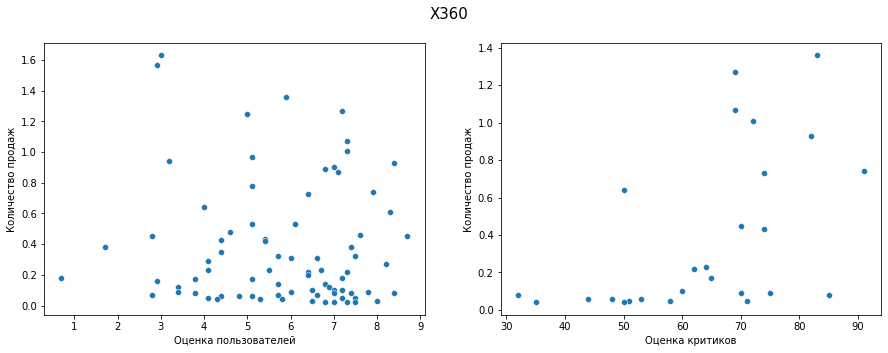

Корреляция между отзывами критиков и продажами:  0.5256325825189971
Корреляция между отзывами пользователей и продажами: -0.06923150041615936


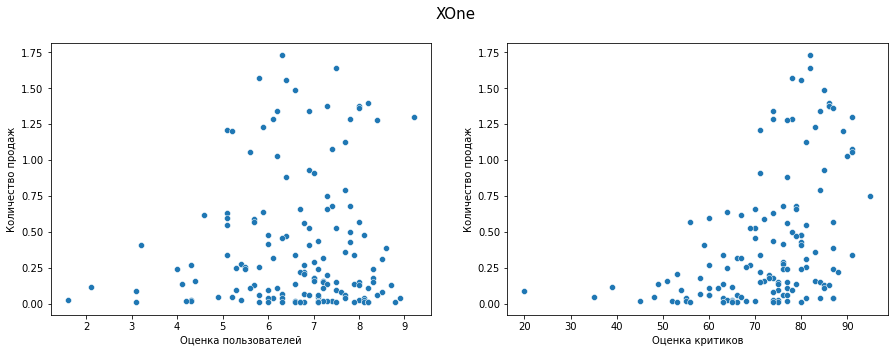

Корреляция между отзывами критиков и продажами:  0.4481976974045557
Корреляция между отзывами пользователей и продажами: 0.07344392517229589


In [51]:
# Вычисляем корреляцию и строим диаграмму рассеивания для остальных платформ
top_5 = ['PS4', 'WiiU', 'X360', 'XOne']
for plat in top_5:
    data_5 = actual_data[actual_data['platform'] == plat]
    fig, ax = plt.subplots(1, 2, figsize=(15,5))
    sns.scatterplot(x='user_score', y='sum_profit', data=data_5, ax=ax[0])
    sns.scatterplot(x='critic_score', y='sum_profit', data=data_5, ax=ax[1])
    fig.suptitle(plat, fontsize=15)
    ax[0].set(xlabel='Оценка пользователей')
    ax[1].set(xlabel='Оценка критиков')
    ax[0].set(ylabel='Количество продаж')
    ax[1].set(ylabel='Количество продаж')
    plt.show()
    print("Корреляция между отзывами критиков и продажами: ", data_5['critic_score'].corr(data_5['sum_profit']))
    print("Корреляция между отзывами пользователей и продажами:", data_5['user_score'].corr(data_5['sum_profit']))

Для платформы WiiU корреляция между продажами и оценками критиков и корреляция между продажами и оценками пользователей практически одинаковы. (0.37 и 0.39 соответственно). Для остальных платформ оценка критиков имеет гораздо большее значение, нежели оценка пользователей.

In [52]:
actual_data['genre'].value_counts()

Action          599
Role-Playing    211
Adventure       185
Sports          144
Misc            108
Shooter         100
Racing           65
Fighting         57
Simulation       42
Strategy         37
Platform         35
Puzzle           14
Name: genre, dtype: int64

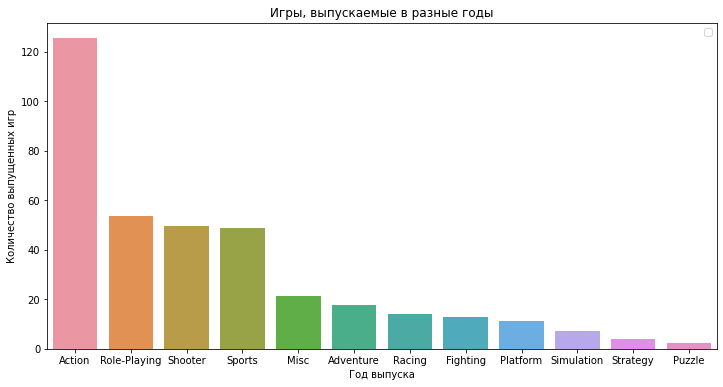

In [53]:
# Построим график распределения игр по жанрам
games_on_period = actual_data.pivot_table(index='genre', values='sum_profit', aggfunc='sum').sort_values(by='sum_profit', ascending=False)
games_on_period = games_on_period.reset_index().rename_axis(None, axis=1)
plt.figure(figsize=(12,6))
sns.barplot(data=games_on_period, x='genre', y='sum_profit')
plt.title("Игры, выпускаемые в разные годы")
plt.xlabel("Год выпуска")
plt.ylabel("Количество выпущенных игр")
plt.legend('')

Самый прибыльный жанр - экшн. Головоломка на последнем месте.

# 3. Портрет пользователя каждого региона

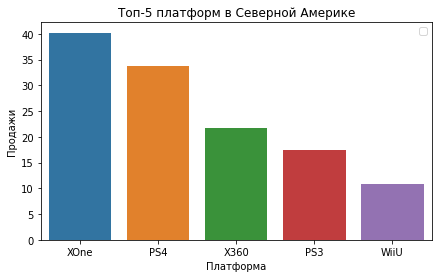

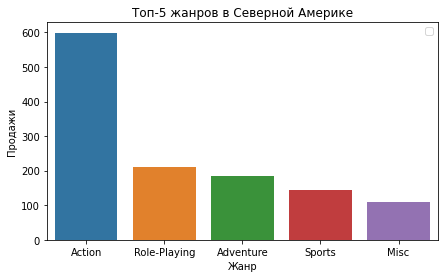

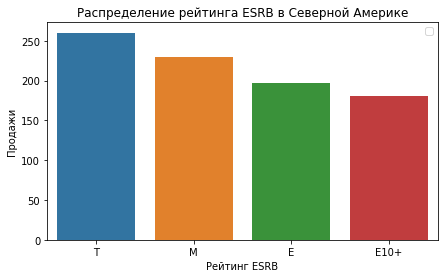

In [54]:
# Пользователи из NA
top_5_na_pl = actual_data.pivot_table(index='platform', values='na_sales', aggfunc='sum').sort_values(by='na_sales', ascending=False).head(5)
top_5_na_pl = top_5_na_pl.reset_index().rename_axis(None, axis=1)
plt.figure(figsize=(7,4))
sns.barplot(data=top_5_na_pl, x='platform', y='na_sales')
plt.title("Топ-5 платформ в Северной Америке")
plt.xlabel("Платформа")
plt.ylabel("Продажи")
plt.legend('') # Топ-5 платформ

top_5_na_gr = actual_data.pivot_table(index='genre', values='na_sales', aggfunc='count').sort_values(by='na_sales', ascending=False).head(5)
top_5_na_gr = top_5_na_gr.reset_index().rename_axis(None, axis=1)
plt.figure(figsize=(7,4))
sns.barplot(data=top_5_na_gr, x='genre', y='na_sales')
plt.title("Топ-5 жанров в Северной Америке")
plt.xlabel("Жанр")
plt.ylabel("Продажи")
plt.legend('') # Жанры

top_5_na_rt = actual_data[actual_data['rating'] != 'no'].pivot_table(index='rating', values='na_sales', aggfunc='count').sort_values(by='na_sales', ascending=False)
top_5_na_rt = top_5_na_rt.reset_index().rename_axis(None, axis=1)
plt.figure(figsize=(7,4))
sns.barplot(data=top_5_na_rt, x='rating', y='na_sales')
plt.title("Распределение рейтинга ESRB в Северной Америке")
plt.xlabel("Рейтинг ESRB")
plt.ylabel("Продажи")
plt.legend('') # Рейтинг

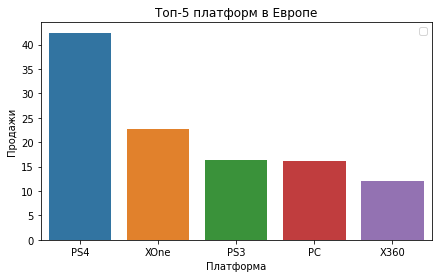

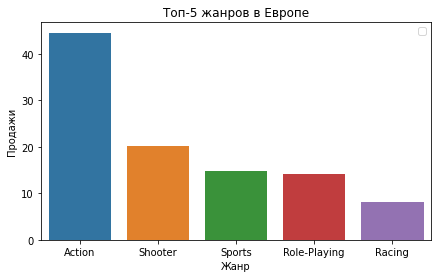

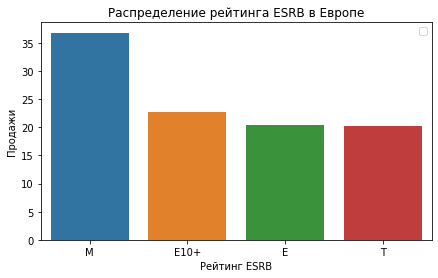

In [55]:
# Пользователи из Европы
top_5_eu = actual_data.pivot_table(index='platform', values='eu_sales', aggfunc='sum').sort_values(by='eu_sales', ascending=False).head(5)
top_5_eu = top_5_eu.reset_index().rename_axis(None, axis=1)
plt.figure(figsize=(7,4))
sns.barplot(data=top_5_eu, x='platform', y='eu_sales')
plt.title("Топ-5 платформ в Европе")
plt.xlabel("Платформа")
plt.ylabel("Продажи")
plt.legend('') # Топ-5 платформ

top_5_eu_gr = actual_data.pivot_table(index='genre', values='eu_sales', aggfunc='sum').sort_values(by='eu_sales', ascending=False).head(5)
top_5_eu_gr = top_5_eu_gr.reset_index().rename_axis(None, axis=1)
plt.figure(figsize=(7,4))
sns.barplot(data=top_5_eu_gr, x='genre', y='eu_sales')
plt.title("Топ-5 жанров в Европе")
plt.xlabel("Жанр")
plt.ylabel("Продажи")
plt.legend('') # Жанры

top_5_eu_rt = actual_data[actual_data['rating'] != 'no'].pivot_table(index='rating', values='eu_sales', aggfunc='sum').sort_values(by='eu_sales', ascending=False)
top_5_eu_rt = top_5_eu_rt.reset_index().rename_axis(None, axis=1)
plt.figure(figsize=(7,4))
sns.barplot(data=top_5_eu_rt, x='rating', y='eu_sales')
plt.title("Распределение рейтинга ESRB в Европе")
plt.xlabel("Рейтинг ESRB")
plt.ylabel("Продажи")
plt.legend('') # Рейтинг

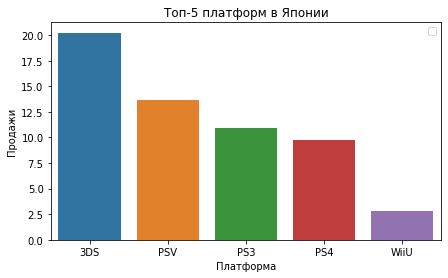

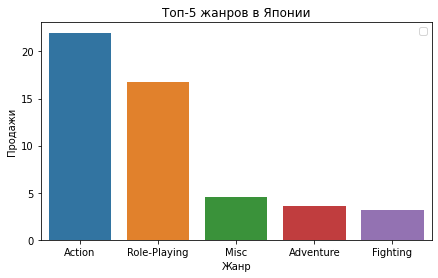

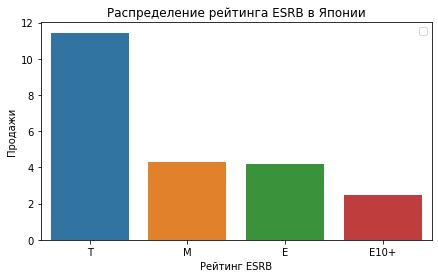

In [56]:
# Пользователи из Японии
top_5_jp = actual_data.pivot_table(index='platform', values='jp_sales', aggfunc='sum').sort_values(by='jp_sales', ascending=False).head(5)
top_5_jp = top_5_jp.reset_index().rename_axis(None, axis=1)
plt.figure(figsize=(7,4))
sns.barplot(data=top_5_jp, x='platform', y='jp_sales')
plt.title("Топ-5 платформ в Японии")
plt.xlabel("Платформа")
plt.ylabel("Продажи")
plt.legend('')

top_5_jp_gr = actual_data.pivot_table(index='genre', values='jp_sales', aggfunc='sum').sort_values(by='jp_sales', ascending=False).head(5)
top_5_jp_gr = top_5_jp_gr.reset_index().rename_axis(None, axis=1)
plt.figure(figsize=(7,4))
sns.barplot(data=top_5_jp_gr, x='genre', y='jp_sales')
plt.title("Топ-5 жанров в Японии")
plt.xlabel("Жанр")
plt.ylabel("Продажи")
plt.legend('') # Жанры

top_5_jp_rt = actual_data[actual_data['rating'] != 'no'].pivot_table(index='rating', values='jp_sales', aggfunc='sum').sort_values(by='jp_sales', ascending=False)
top_5_jp_rt = top_5_jp_rt.reset_index().rename_axis(None, axis=1)
plt.figure(figsize=(7,4))
sns.barplot(data=top_5_jp_rt, x='rating', y='jp_sales')
plt.title("Распределение рейтинга ESRB в Японии")
plt.xlabel("Рейтинг ESRB")
plt.ylabel("Продажи")
plt.legend('') # Рейтинг

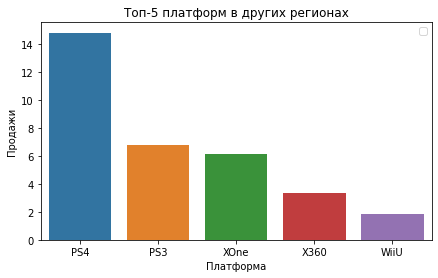

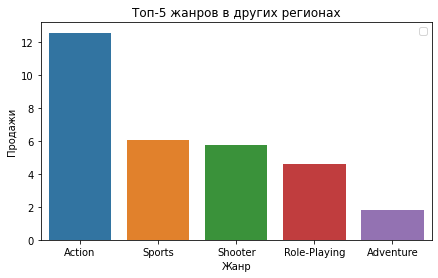

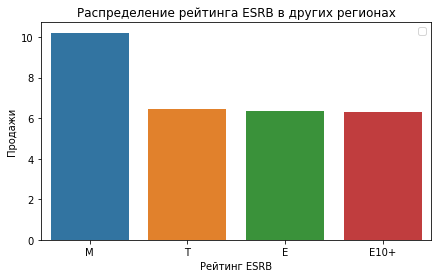

In [57]:
# Пользователи из других регионов
top_5_other = actual_data.pivot_table(index='platform', values='other_sales', aggfunc='sum').sort_values(by='other_sales', ascending=False).head(5)
top_5_other = top_5_other.reset_index().rename_axis(None, axis=1)
plt.figure(figsize=(7,4))
sns.barplot(data=top_5_other, x='platform', y='other_sales')
plt.title("Топ-5 платформ в других регионах")
plt.xlabel("Платформа")
plt.ylabel("Продажи")
plt.legend('')

top_5_other_gr = actual_data.pivot_table(index='genre', values='other_sales', aggfunc='sum').sort_values(by='other_sales', ascending=False).head(5)
top_5_other_gr = top_5_other_gr.reset_index().rename_axis(None, axis=1)
plt.figure(figsize=(7,4))
sns.barplot(data=top_5_other_gr, x='genre', y='other_sales')
plt.title("Топ-5 жанров в других регионах")
plt.xlabel("Жанр")
plt.ylabel("Продажи")
plt.legend('') # Жанры


top_5_other_rt = actual_data[actual_data['rating'] != 'no'].pivot_table(index='rating', values='other_sales', aggfunc='sum').sort_values(by='other_sales', ascending=False)
top_5_other_rt = top_5_other_rt.reset_index().rename_axis(None, axis=1)
plt.figure(figsize=(7,4))
sns.barplot(data=top_5_other_rt, x='rating', y='other_sales')
plt.title("Распределение рейтинга ESRB в других регионах")
plt.xlabel("Рейтинг ESRB")
plt.ylabel("Продажи")
plt.legend('') # Рейтинг

Вывод:
- Самые популярные платформы в Европе и других регионах - это PS4, в Северной Америке - XOne, в Японии - 3DS;
- Платформа 3DS - самая популярная в Японии. В остальных регионах она отсутствует даже в топ-5;
- PS3 входит в тройку самых продаваемых во всех регионах, кроме Северной Америки;
- Экшн является самым популярным жанром во всех регионах.
- Жанр игры "ролевые" входит в 5-ку самых популярных жанров в каждом регионе;
- Жанр игры "спорт" популярен везде, кроме Японии;
- Игры с рейтингом 'M' (для взрослых) - самые поплуярные в Японии и других регионах. Игры с рейтингом 'T' (для подростков от 13 лет) - самые популярные в Северной Америке и Европе.
- Игры с рейтингом 'E' (для всех) занимают 3-ье место по популярности во всех регионах исследования.

# 4. Проверка гипотез

- Нулевая гипотеза - средние пользовательские рейтинги платформ Xbox One и PC одинаковые.
- Альтернативная гипотеза - средние пользовательские рейтинги платформ Xbox One и PC различны.

In [69]:
xone_user_score = data[(data['year_of_release'] >= 2003) & (data['platform'] == 'XOne') & (data['user_score'].notnull())]['user_score'] 
pc_user_score = data[(data['year_of_release'] >= 2003) & (data['platform'] == 'PC') & (data['user_score'].notnull())]['user_score']

alpha = .05

results = st.ttest_ind(xone_user_score, pc_user_score, equal_var = True)

print('p-значение:', results.pvalue)


if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.0003294040999041141
Отвергаем нулевую гипотезу


Нулевая гипотеза отвергунта. С вероятностью в почти 0,03% можно получить различные рейтинги этих двух платформ. Фактически, такой вероятности не существует.

- Нулевая гипотеза - средние пользовательские рейтинги жанров Action и Sports одинаковые.
- Альтернативная гипотеза - средние пользовательские рейтинги жанров Action и Sports разные.

In [68]:
xone_user_score = data[(data['year_of_release'] >= 2003) & (data['genre'] == 'Action') & (data['user_score'].notnull())]['user_score'] 
pc_user_score = data[(data['year_of_release'] >= 2003) & (data['genre'] == 'Sports') & (data['user_score'].notnull())]['user_score']

alpha = .05

results = st.ttest_ind(xone_user_score, pc_user_score, equal_var = True)

print('p-значение:', results.pvalue)


if results.pvalue < alpha:
    print("Отвергаем нулевую гипотезу")
else:
    print("Не получилось отвергнуть нулевую гипотезу")

p-значение: 0.0012094914291146178
Отвергаем нулевую гипотезу


Нулевая гипотеза отвергнута. С вероятностью в 0.1% можно получить одинаковые рейтинги для этих двух жанров. Фактически, такой вероятности почти что не существует.

# 5. Общий вывод

- Провели подготовку данных.Некоторые строки с пропусками были удалены, некоторые пропуски были оставлены без изменений;
- Заменили тип данных некоторых столбцов для экономии ячеек памяти и быстроты работы программы;
- После провели исследовательский анализ данных. Было обнаружено, что резкий скачок выпуска игр начался с 1995 по 2009 год. После 2009-го года начался такой же резкий спад. Это связано с развитием мобильных телефонов и приложений для них;
- Выявили топ-5 консолей по продажам (PS2, X360, PS3, Wii, DS). Средняя продолжительность жизни консоли - около 10-ти лет, пик продажи - 5 лет с её выпуска;
- Самая прибыльная игровая консоль за всё время - PS2;
- Выбрали актуальный период - с 2014 по 2016 годы;
- Выявили закономерность между оценками критиков и пользователей и суммарными продажами платформ. Оценки критиков имеют "больший вес", нежели оценки пользователей;
- Определили самый популярный жанр - экшн. На последнем месте располагается головоломки;
- Позже выявили портреты пользователей каждого региона: 
1. Северная Америка. Здесь самые популярные платформы за актульный период - это XOne, PS4, X360; самые популярные жанры - это экшн, ролевые игры и приключения; в основном популярны игры с рейтингом 'T' - для подростков от 13-ти лет, следом идет рейтинг 'M' - для взрослых.
2. Европа. Самые популярные платформы - это PS4, XOne, PS3; самые популярные жанры - это экшн, шутеры и спорт; в основном популярны игры с рейтингом 'M' - для взрослых, следом идет рейтинг 'E10+' - для детей от 10 лет.
3. Япония. Самые популярные платформы - это 3DS, PSV, PS3; самые популярные жанры - это экшн, ролевые игры и аркады; в основном популярны игры с рейтингом 'T' - от 13 лет, следом идет рейтинг 'М' - для взрослых.
4. Другие страны. Самые популярные платформы - это PS4, PS3, XOne; самые популярные жанры - это экшн, спорт и шутеры; в основном популярны игры с рейтингом 'М' - для взрослых, следом идет рейтинг 'T' - от 13 лет.
- Далее идет проверка гипотез. Гипотеза о том, что средние пользовательские рейтинги платформ Xbox One и PC одинаковые, была отвергнута. Гипотезу "средние пользовательские рейтинги жанров Action и Sports одинаковые" так же удалось опровергнуть.

Ожидается, что продажи будут расти у PS4 и XOne. Самый популярный рейтинг ESRB 'M' (для взрослых) и 'T' (для подростков от 13-ти лет), а самый популярный жанр - экшн.